Import Library

In [1]:
import os, zipfile, shutil, PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

Spliting Folder

In [2]:
!pip install split-folders

import splitfolders
# splitfolders.ratio('../img/digits', output="output", seed=1337, ratio=(.8, 0.2)) 

Defaulting to user installation because normal site-packages is not writeable


Copying files: 35500 files [02:06, 280.69 files/s]


In [12]:
BATCH = 64
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [13]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train/",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

validation_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val/",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

Found 28400 files belonging to 35 classes.
Found 7100 files belonging to 35 classes.


In [14]:
class_names = train_loader.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


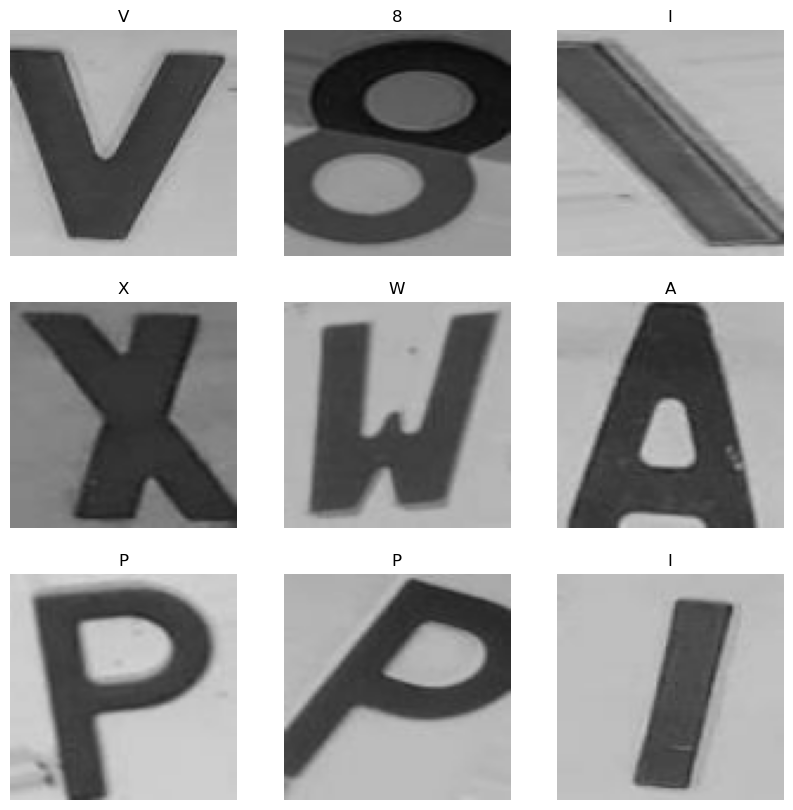

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_loader.cache().prefetch(buffer_size=AUTOTUNE)

Implementasi Model Sequential

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Implementasi Conv2D Maxpooling Layer

In [18]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
  
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

Implementation of the Callback Function

In [20]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999 and logs.get('val_accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [21]:
epochs = 15 
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks = [callbacks]
)

Epoch 1/15


444/444 [==============================] - 120s 243ms/step - loss: 1.1207 - accuracy: 0.6778 - val_loss: 6.2842 - val_accuracy: 0.3613
Epoch 2/15
444/444 [==============================] - 114s 257ms/step - loss: 0.2211 - accuracy: 0.9317 - val_loss: 8.8491 - val_accuracy: 0.3525
Epoch 3/15
444/444 [==============================] - 122s 276ms/step - loss: 0.1381 - accuracy: 0.9575 - val_loss: 9.2949 - val_accuracy: 0.3807
Epoch 4/15
444/444 [==============================] - 116s 260ms/step - loss: 0.1016 - accuracy: 0.9668 - val_loss: 11.3346 - val_accuracy: 0.3701
Epoch 5/15
444/444 [==============================] - 117s 264ms/step - loss: 0.0809 - accuracy: 0.9748 - val_loss: 9.6669 - val_accuracy: 0.3766
Epoch 6/15
444/444 [==============================] - 113s 253ms/step - loss: 0.0654 - accuracy: 0.9799 - val_loss: 10.9424 - val_accuracy: 0.3901
Epoch 7/15
444/444 [==============================] - 125s 282ms/step - loss: 0.0601 - accuracy: 0.9814 - val_loss: 11.0388 - val_acc

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

 Plot the Model Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

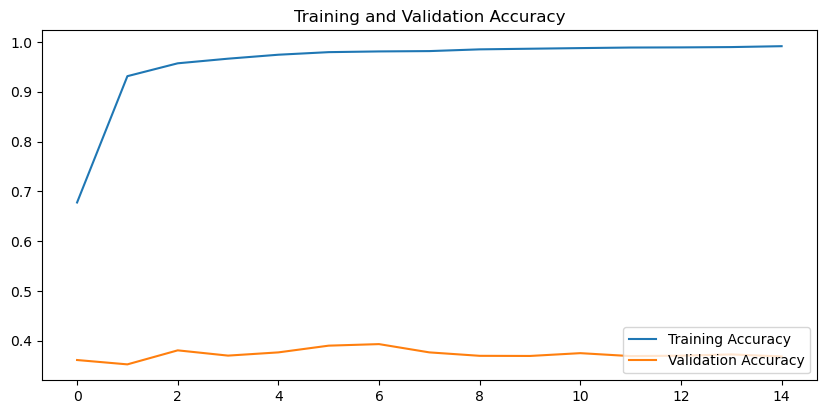

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Plot the Model Loss

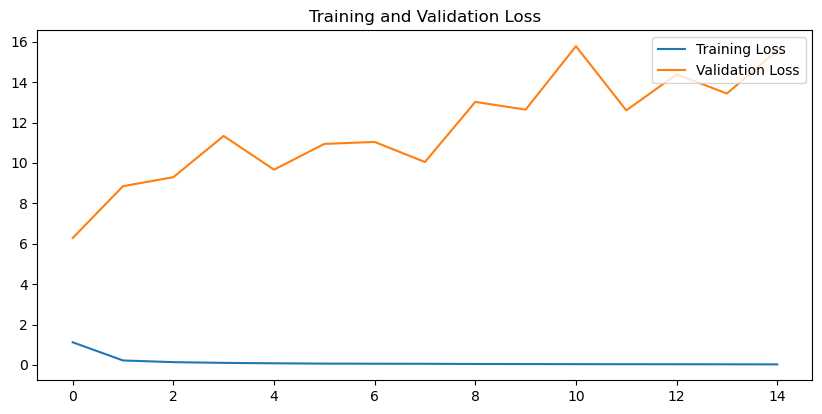

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\garri\AppData\Local\Temp\tmp3p3ap6p9\assets


INFO:tensorflow:Assets written to: C:\Users\garri\AppData\Local\Temp\tmp3p3ap6p9\assets


Save the Model in TF-Lite Format

In [ ]:
with tf.io.gfile.GFile('saved_models/model_cnn_2.tflite', 'wb') as f:
  f.write(tflite_model)
  
# Save model as h5
model.save('saved_models/model_cnn_2.h5')